<a href="https://colab.research.google.com/github/VasylTsykolanov/wwd/blob/main/Inference_Animals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

**Connect to personal drive where animals_infrence folder is stored**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/My Drive')

In [ ]:
pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import wget

In [ ]:
#Clone tensorflow github repo
if not os.path.exists('/animals_inference/models/research/object_detection'):
    !git clone https://github.com/tensorflow/models '/animals_inference/models'

In [ ]:
!apt-get install protobuf-compiler
!cd animals_inference/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 

In [ ]:
pip install object_detection

In [ ]:
import object_detection

In [ ]:
#If execution of this script ends with OK (skipped=1), you can proceed
!python '/content/drive/My Drive/animals_inference/model_builder_tf2_test.py'

In [ ]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [ ]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file('/content/drive/My Drive/animals_inference/my_ssd_mobnet/pipeline.config')
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore('/content/drive/My Drive/animals_inference/my_ssd_mobnet/ckpt-6').expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [ ]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap('/content/drive/My Drive/animals_inference/labels/label_map.pbtxt')

In [ ]:
IMAGE_PATH = os.path.join('/content/drive/My Drive/animals_inference/images', '200d8a0e-042.jpg')

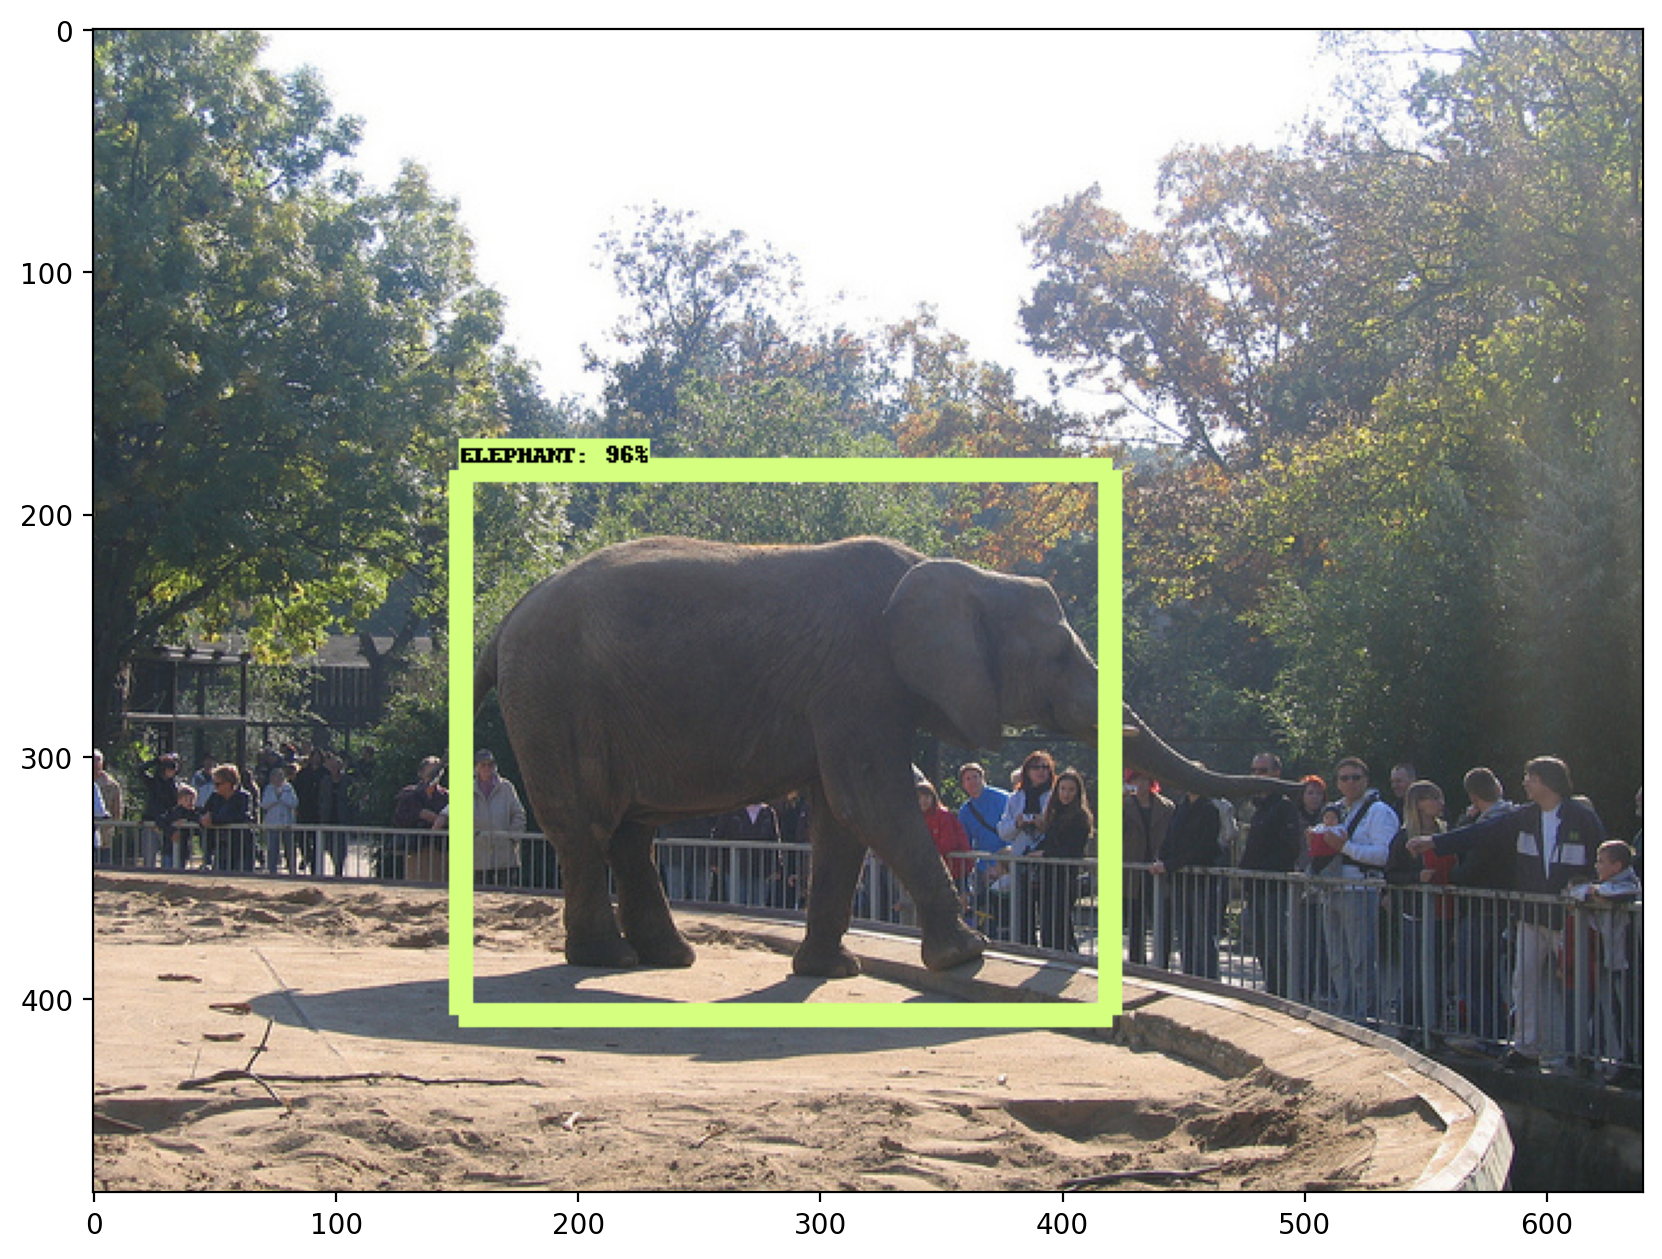

In [ ]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False,
            line_thickness=10)

plt.figure(figsize=(10,10), dpi=200)
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
print(category_index[detections['detection_classes'][0]+label_id_offset]["name"])

ELEPHANT
